# Project 1

## 1. Introduction

### Challenge

The objective of this project is to build a machine learning model that can predict four key repair outcomes of CRISPR-Cas9 editing experiments based on provided DNA sequences. Specifically, the aim is to accurately predict:
- **Fraction_Insertions**: The fraction of indel reads that resulted in insertions.
- **Avg_Deletion_Length**: The average length of deletions observed.
- **Indel_Diversity**: A measure of the variability in indel types and lengths.
- **Fraction_Frameshifts**: The fraction of repair outcomes that lead to a frameshift mutation.

The primary goal of this project is predictive accuracy - to develop a machine learning model capable of reliably predicting the specified CRISPR-Cas9 repair outcomes based on the input features. This makes the problem prediction-focused, rather than inferential, as the emphasis is on optimizing performance metrics (e.g., R², Mean Squared Error) rather than understanding the specific causal relationships between the predictors and outcomes.

Let's visualise which models look the best to use according to our objective:

**Figure 1.** Interpretability vs accuracy trade-off: main models and their improvement directions.
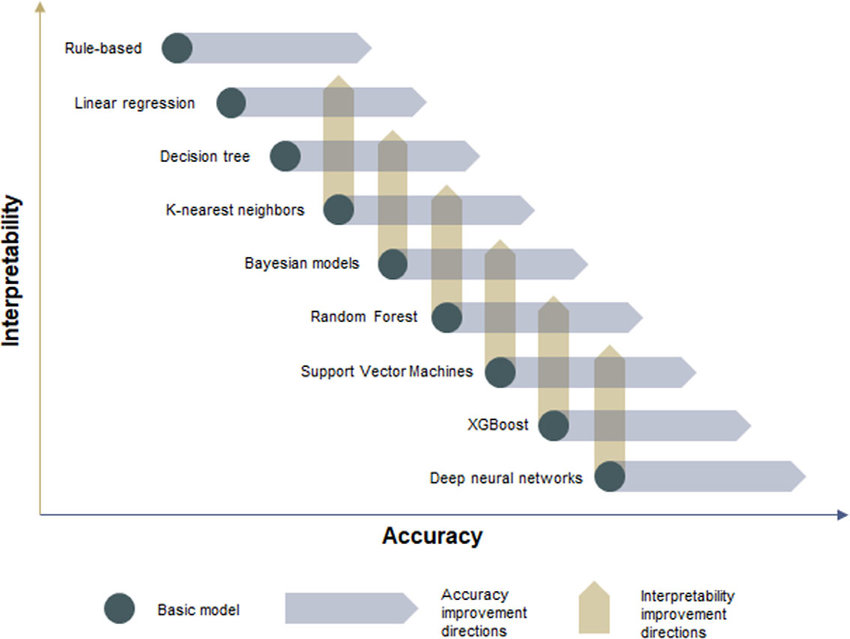

*Note.* From "The accuracy versus interpretability trade-off in fraud detection model", by A. Nesvijevskaia, S. Ouillade, P. Guilmin and J. Zucker, 2021, *Data & Policy*, *3*(e12), Figure 6(doi:10.1017/dap.2021.3)


By interpretating the image we can conclude that the best supervised model for this challenge would, in theory, be the **XGBoost**. 

The data used to make this model was obtained by Leenay et al. (2019) and, in the same article, a machine learning model (SPROUT) was made in order to predict the length, probability and sequence of nucleotide insertions and deletions, and, consequently, facilitate design of SpCas9 guide RNAs in therapeutically important primary human cells. 

Therefore, to construct our model we will take into account some important considerations the authors have taken into account in the SPROUP model. For instance, we know that the model takes as input the 20 nucleotides of the spacer sequence plus the protospacer adjacent motif (PAM) sequence. Therefore, we will try this using this two features as input/predictor variables. Moreover, the model was trained and evaluated using five-fold cross validation, we will keep this in mind for later on our project. 

## 2. Library Importation

To analyze and model the CRISPR-Cas9 DNA sequence data, we imported several key libraries:

In [ ]:
# Data manipulation and analysis
import pandas as pd        # For handling and analyzing data (DataFrames)
import numpy as np         # For numerical operations 
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns      # For advanced statistical visualizations

# Preprocessing and feature engineering
from sklearn.preprocessing import OneHotEncoder        # To encode categorical features

# Model building and evaluation
from sklearn.multioutput import MultiOutputRegressor   # Allows multi-target regression 
from sklearn.model_selection import GridSearchCV, cross_val_score  # For hyperparameter tuning and cross-validation
from sklearn.model_selection import learning_curve     # For evaluating model performance with learning curves

# SciPy Sparse Matrix for efficient storage of large sparse matrices
from scipy.sparse import hstack   # Used to combine multiple sparse matrices into one matrix

# Regular expression and Counter for feature extraction
import re  # For working with regular expressions
from collections import Counter   # For counting frequency of k-mers or other features


## 3. Data Loading and Preprocessing

To begin the analysis, we first load the training and testing datasets, provided in CSV format, which contain DNA sequence data and associated repair outcomes.

In [114]:
# Load the training and testing data from CSV files
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Set 'Id' column as the index for easy reference to each record
train_data = train_data.set_index("Id")
test_data = test_data.set_index("Id")

The training data (**train_data**) contains labeled examples that will be used to train the model, while the test data (**test_data**) contains DNA sequences for which we want to predict the repair outcomes. Setting the "Id" column as the index helps us keep track of individual sequences throughout the preprocessing and prediction stages.

### 3.1 Analyzing each dataset

Once the datasets are loaded, we'll check their structure and basic statistics to ensure they are properly formatted and contain the expected data.

* **train_data**

In [115]:
train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1065 entries, 0 to 1064
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GuideSeq              1065 non-null   object 
 1   Fraction_Insertions   1065 non-null   float64
 2   Avg_Deletion_Length   1065 non-null   float64
 3   Indel_Diversity       1065 non-null   float64
 4   Fraction_Frameshifts  1065 non-null   float64
dtypes: float64(4), object(1)
memory usage: 49.9+ KB


,GuideSeq,Fraction_Insertions,Avg_Deletion_Length,Indel_Diversity,Fraction_Frameshifts
Id,,,,,
0,CTGCAGGGCTAGTTTCCTATAGG,0.069572,4.301844,3.536538,0.807375
1,GAGATGCGGACCACCCAGCTGGG,0.287647,10.814444,3.871165,0.665696
2,GCAAACGGAAGTGCAATTGTCGG,0.137004,9.888889,3.931298,0.684823
3,GTCATCGCTGAGTTGAGGAAGGG,0.093889,4.527812,3.523067,0.753003
4,ATATGATTATCCCTGCACAAGGG,0.526525,6.415644,2.828101,0.887214


We are able to check that there are 5 columns:
- **GuideSeq**: The DNA sequence used in the CRISPR-Cas9 knockout experiments. This sequence includes the 20-nucleotide guide RNA sequence plus the PAM sequence.
- **Fraction_Insertions**: The fraction of indel reads that resulted in insertions.
- **Avg_Deletion_Length**: The average length of deletions observed.
- **Indel_Diversity**: A measure of the variability in indel types and lengths.
- **Fraction_Frameshifts**: The fraction of repair outcomes that lead to a frameshift mutation.

Moreover, we can conclude that there are 1065 entries and each column has a full set of non-null values, meaning there are no missing entries in this dataset. 

Given that the response variables are continuous, this project is framed as a **regression problem** where the objective is to predict numerical values for each outcome variable.


Next, the describe() method provides basic statistics like mean, standard deviation, min, max, and percentiles for each of the numerical columns, giving insight into the distribution of the repair outcomes

In [116]:
train_data.describe()

,Fraction_Insertions,Avg_Deletion_Length,Indel_Diversity,Fraction_Frameshifts
count,1065.000000,1065.000000,1065.000000,1065.000000
mean,0.209327,7.370845,3.800805,0.698444
std,0.153476,3.003263,0.709694,0.123423
min,0.001168,2.346479,1.151684,0.001676
25%,0.088558,5.421346,3.357909,0.641393
50%,0.164405,6.977368,3.857114,0.714457
75%,0.292504,8.773226,4.302568,0.780449
max,0.831198,46.027027,5.548348,0.954305


* **test_data**

In [117]:
test_data.info()
test_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   GuideSeq  304 non-null    object
dtypes: object(1)
memory usage: 4.8+ KB


,GuideSeq
Id,
0,TGTGCAATATCTGGTACTAAGGG
1,TGTCTGGCCAGCAGAATACAGGG
2,ACTGAGAGTGGATCCGAAAGTGG
3,GTTCTGCACCAGCACATTCACGG
4,ACTGGATGGACAAGACTGGTGGG


The test_data consists of 304 entries and only contains one column:

* **GuideSeq**: The DNA sequence used in the CRISPR-Cas9 experiments.

Furthermore, we can confirm that the test_data does not contain any missing values.

### 3.2 Preparing Test Data for Predictions

To facilitate the later prediction of the four target variables, we add new columns in the test data (`test_data`) for each repair outcome (`Fraction_Insertions`, `Avg_Deletion_Length`, `Indel_Diversity`, and `Fraction_Frameshifts`). Initially, these columns are filled with `NaN` values, indicating that these are the variables we intend to predict.


In [ ]:
# New columns with NaN values
target_columns = ['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts']

for col in target_columns:
    test_data[col] = np.nan

# Displaying the modified test_data
test_data.head()

,GuideSeq,Fraction_Insertions,Avg_Deletion_Length,Indel_Diversity,Fraction_Frameshifts
Id,,,,,
0,TGTGCAATATCTGGTACTAAGGG,NaN,NaN,NaN,NaN
1,TGTCTGGCCAGCAGAATACAGGG,NaN,NaN,NaN,NaN
2,ACTGAGAGTGGATCCGAAAGTGG,NaN,NaN,NaN,NaN
3,GTTCTGCACCAGCACATTCACGG,NaN,NaN,NaN,NaN
4,ACTGGATGGACAAGACTGGTGGG,NaN,NaN,NaN,NaN


### 3.3 Defining X (Features/Input Variables) and y (Targets/Output Variables)

To prepare the data for training, we specified the feature variables (X) and target variables (y). The feature variables are the DNA sequence data that will serve as the predictors in the model, while the target variables are the four repair outcomes to be predicted.

In [147]:
# Specify target variables (y) - the outcomes we aim to predict
y_train = train_data[['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts']].values
y_test = test_data[['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts']].values

# Specify feature variables (X) - the data used for prediction, excluding the GuideSeq and target columns
X_train = train_data.drop(['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts'], axis=1)
X_test = test_data.drop(['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts'], axis=1)

### 3.4  Preprocessing the DNA Sequences

#### 3.4.1 Separating the DNA sequence

Let’s break down the 23-nucleotide sequences into two distinct parts, as the authors of the article have done. The first part consists of the first 20 nucleotides, while the second part, the last 3 nucleotides, corresponds to the PAM. 

In [ ]:
# Extracting the GuideSeq column as a list of sequences
guide_seqs_train = X_train['GuideSeq']
guide_seqs_test = X_test['GuideSeq']

# Spliting each sequence into two parts: first 20 nucleotides and last 3 nucleotides
X_train_first_20 = [seq[:20] for seq in guide_seqs_train]
X_train_PAM = [seq[20:] for seq in guide_seqs_train]

X_test_first_20 = [seq[:20] for seq in guide_seqs_test]
X_test_PAM = [seq[20:] for seq in guide_seqs_test]

#### 3.4.2 One-Hot Encoding the DNA Sequences

We apply One-Hot Encoding to the DNA sequences, converting each nucleotide into a binary vector representation. In general, dummy variables are introduced to encode categorical features. In machine learning, this is more often called **one-hot encoding**.

In [ ]:
# Initializing encoders
encoder_20 = OneHotEncoder(categories=[['A', 'T', 'C', 'G']]*20)
encoder_PAM = OneHotEncoder(categories=[['A', 'T', 'C', 'G']]*3)

# Transforming the first 20 nucleotides
X_train_20_encoded = encoder_20.fit_transform([list(seq) for seq in X_train_first_20])
X_test_20_encoded = encoder_20.transform([list(seq) for seq in X_test_first_20])

# Transforming the PAM sequence
X_train_PAM_encoded = encoder_PAM.fit_transform([list(seq) for seq in X_train_PAM])
X_test_PAM_encoded = encoder_PAM.transform([list(seq) for seq in X_test_PAM])

Next, we concatenate the encoded first 20 nucleotides and PAM sequence features for each dataset:

In [ ]:
# Concatenating the encoded features
X_train_combined = hstack([X_train_20_encoded, X_train_PAM_encoded])
X_test_combined = hstack([X_test_20_encoded, X_test_PAM_encoded])

#### 3.4.3 Other considerations

Other ways of enconding the DNA sequences were tested. These included:

- **K-mers**: This method involves breaking down sequences into overlapping or non-overlapping substrings (k-mers) of length *k*. This approach captures short sequence patterns which can be informative for understanding sequence-specific outcomes.

        For k=2:
        - Cross-validation scores (R2): [-0.08109762 -0.15496109 -0.06624557 -0.04546006 -0.16701565]
        - Mean cross-validation score (R2): -0.10295599686928383
        - Standard deviation of cross-validation scores: 0.04886592917736405
        
        For k=3:
        - Cross-validation scores (R2): [-0.03643673 -0.16604832 -0.05264141 -0.04790556 -0.16029733]
        - Mean cross-validation score (R2): -0.09266587068494904
        - Standard deviation of cross-validation scores: 0.057837976510885514
        
- **N-gram Features**: Similar to k-mers, n-grams break down sequences into smaller segments but are often used in a probabilistic or frequency-based context. This method aims to capture the relationships and co-occurrences of nucleotide sequences within the data.  

         This method was tested with a submission in the kaggle platform. The results weren't promising (R2 = -0.006).

- **Location Features**: These encode positional information about specific nucleotides or motifs relative to key regions, such as the cut site. Location features are particularly useful for understanding sequence-context effects.  

         This method was tested with a submission in the kaggle platform. The results weren't promising (R2 = 0.1).

- **TF-IDF** (Term Frequency-Inverse Document Frequency): This technique, typically used in text analysis, was adapted to quantify the importance of k-mer occurrences within the DNA sequences, emphasizing unique patterns.

         This method was tested with a submission in the kaggle platform. The results weren't promising (R2 = 0.02).

- **Base nucleotide integer encoding**: each nucleotide in the DNA sequence is mapped to a distinct integer value. Specifically, the nucleotides 'A', 'T', 'G', and 'C' are represented as 0, 1, 2, and 3, respectively.

        - Cross-validation scores (R2): [ 0.1695302   0.12949233  0.10076898  0.19827853 -0.00583915]
        - Mean cross-validation score (R2): 0.11844618047061355
        - Standard deviation of cross-validation scores: 0.07051825977289353

- **Position Specific Integer Encoding**: transforms sequence information into a numerical format while preserving the positional relationship of each element in the sequence.

        - Cross-validation scores (R2): [0.17721805 0.06604432 0.13738427 0.20566114 0.06264737]
        - Mean cross-validation score (R2): 0.1297910272690624
        - Standard deviation of cross-validation scores: 0.057680444272471425


Despite the diverse insights provided by these approaches, none achieved the predictive performance of one-hot encoding.

An additional feature, "Microhomology length," was incorporated into the model, but its inclusion did not improve performance as expected, contrary to the authors' findings. This may be due to some of the specific requirements for calculating this feature not being met. As a result, it was ultimately removed from the model.

    - Cross-validation scores (R2): [0.22233637 0.08838482 0.11442841 0.2060983  0.03875483]
    - Mean cross-validation score (R2): 0.13400054602852313
    - Standard deviation of cross-validation scores: 0.07005271539501598


## 4. Data Exploration

Next, a thorough data exploration was conducted for both the input variables and the output variables. This analysis provided valuable insights into the distribution, variability, and patterns within the data.

### 4.1 Visualizing the Input Variables

#### 4.1.1 Nucleotide Composition across sequences

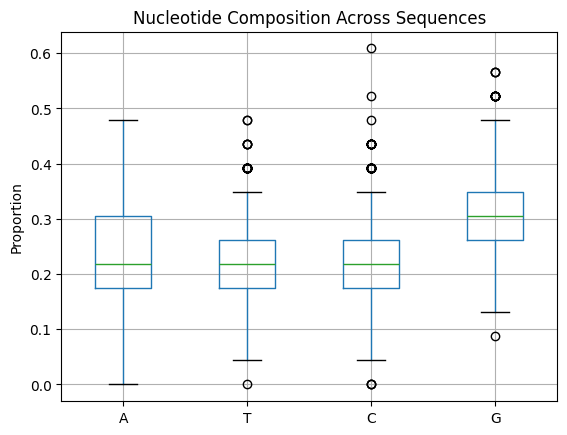

In [ ]:
# Function to calculate nucleotide proportions
def nucleotide_composition(sequence):
    counts = Counter(sequence)
    total = sum(counts.values())
    return {nt: counts[nt] / total for nt in 'ATCG'}

# Applying it to the DNA sequences
compositions = train_data['GuideSeq'].apply(nucleotide_composition)

# Converting to a DataFrame for easier visualization
composition_df = pd.DataFrame(compositions.tolist())

# Plotting nucleotide proportions
composition_df.boxplot()
plt.title('Nucleotide Composition Across Sequences')
plt.ylabel('Proportion')
plt.show()



The boxplot analysis of nucleotide composition reveals that most nucleotides appear to be present in similar proportions. However, the median value for the G nucleotide is noticeably higher. This could suggest a higher occurrence of guanine in the region surrounding the CRISPR target sites, potentially reflecting sequence-specific biases in the DNA sequence. This may be related to the role of the PAM, which often contains a G-rich sequence, influencing the observed distribution of nucleotides.

#### 4.1.2 GC Content Analysis

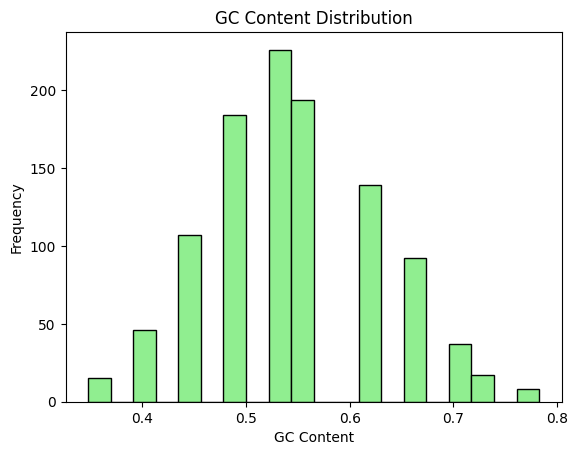

In [ ]:
# Function to calculate GC content
def gc_content(sequence):
    g = sequence.count('G')
    c = sequence.count('C')
    return (g + c) / len(sequence)

# Applying and plotting the GC content
train_data['gc_content'] = train_data['GuideSeq'].apply(gc_content)
plt.hist(train_data['gc_content'], bins=20, color='lightgreen', edgecolor='black')
plt.title('GC Content Distribution')
plt.xlabel('GC Content')
plt.ylabel('Frequency')
plt.show()


#### 4.1.3 Distributions of PAM sequence

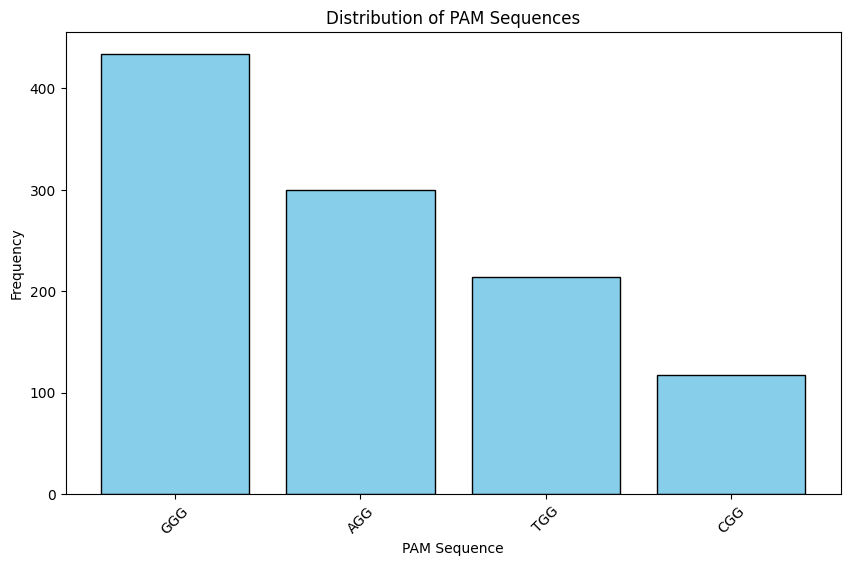

In [ ]:
# Counting the frequency of each unique PAM sequence
pam_counts = Counter(X_train_PAM)

# Converting to a sorted DataFrame for visualization
import pandas as pd
pam_df = pd.DataFrame(pam_counts.items(), columns=['PAM Sequence', 'Count']).sort_values(by='Count', ascending=False)

# Plotting the distribution of PAM sequences
plt.figure(figsize=(10, 6))
plt.bar(pam_df['PAM Sequence'], pam_df['Count'], color='skyblue', edgecolor='black')
plt.title('Distribution of PAM Sequences')
plt.xlabel('PAM Sequence')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


The distribution of PAM sequences revealed that there are only four distinct types: AGG, GGG, CGG, and TGG. Among these, GGG is the most prevalent.

#### 4.1.4 Nucleotide Composition of PAM Sequences

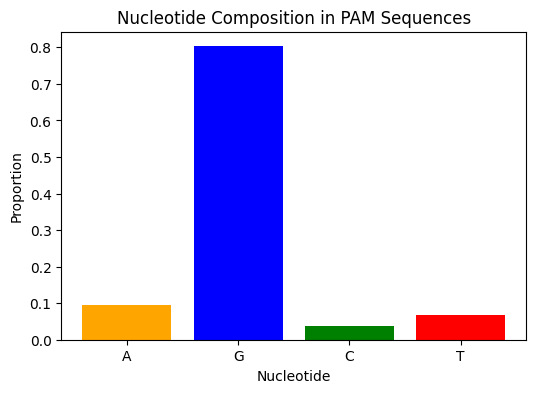

In [ ]:
# Flatten the list of PAM sequences into a single string
all_pam_nucleotides = ''.join(X_train_PAM)

# Counting nucleotide frequencies
pam_nucleotide_counts = Counter(all_pam_nucleotides)
total_pam_nucleotides = sum(pam_nucleotide_counts.values())
pam_nucleotide_proportions = {nt: count / total_pam_nucleotides for nt, count in pam_nucleotide_counts.items()}

# Plotting the nucleotide proportions
plt.figure(figsize=(6, 4))
plt.bar(pam_nucleotide_proportions.keys(), pam_nucleotide_proportions.values(), color=['orange', 'blue', 'green', 'red'])
plt.title('Nucleotide Composition in PAM Sequences')
plt.xlabel('Nucleotide')
plt.ylabel('Proportion')
plt.show()


The nucleotide composition analysis of the PAM sequences revealed that the G nucleotide was by far the most frequent. 

### 4.2 Visualizing the Output Variables

#### 4.2.1 Histograms

Histograms show how the values of a variable are distributed across different bins. This is useful for understanding the frequency of different ranges of values.

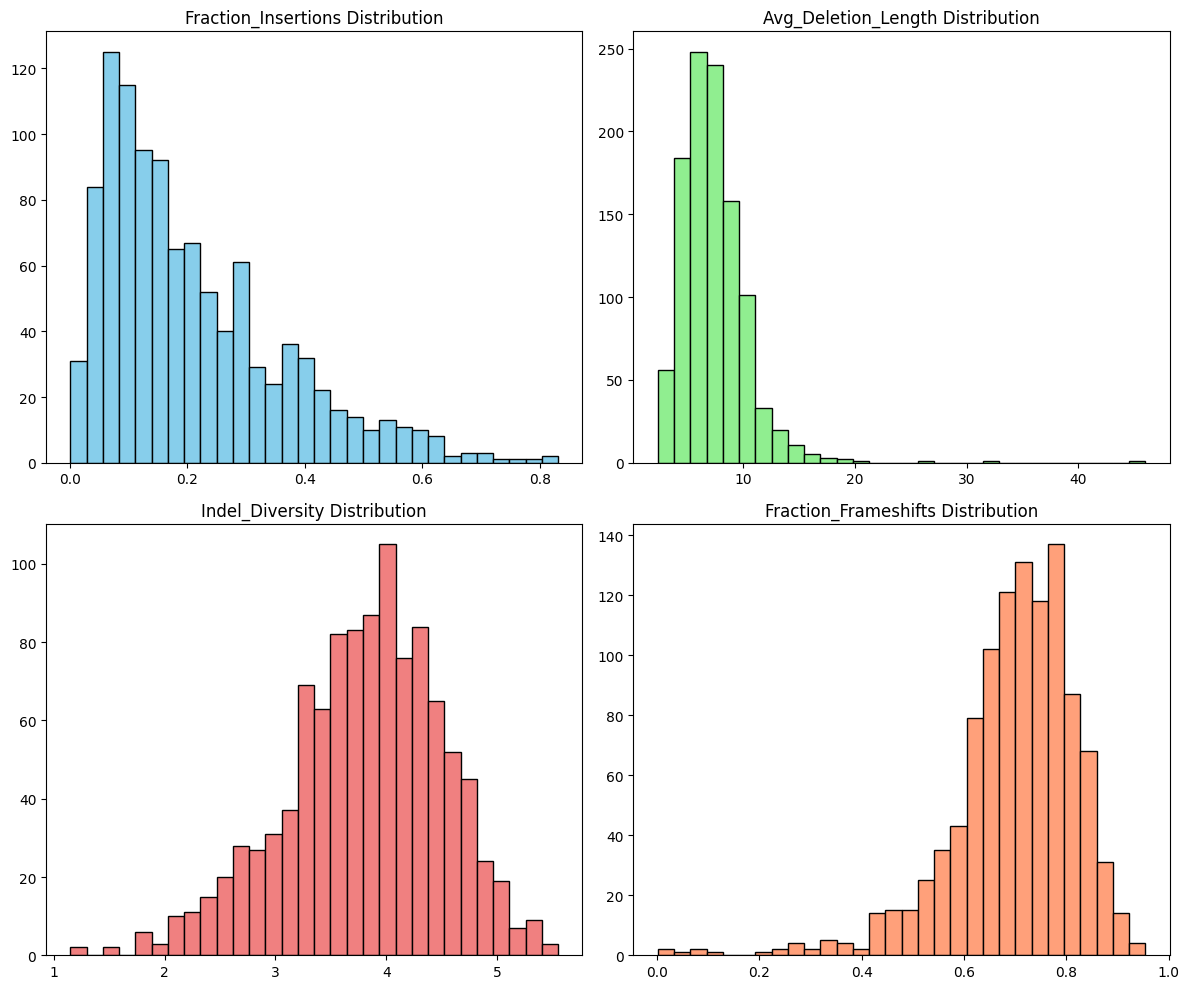

In [33]:
# Set up a figure with multiple subplots for each target variable
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot each target variable in a different subplot
axs[0, 0].hist(y_train[:, 0], bins=30, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Fraction_Insertions Distribution')

axs[0, 1].hist(y_train[:, 1], bins=30, color='lightgreen', edgecolor='black')
axs[0, 1].set_title('Avg_Deletion_Length Distribution')

axs[1, 0].hist(y_train[:, 2], bins=30, color='lightcoral', edgecolor='black')
axs[1, 0].set_title('Indel_Diversity Distribution')

axs[1, 1].hist(y_train[:, 3], bins=30, color='lightsalmon', edgecolor='black')
axs[1, 1].set_title('Fraction_Frameshifts Distribution')

# Adjust layout to make sure titles and axes fit well
plt.tight_layout()
plt.show()

The provided histograms represent the distributions of the four target variables in the dataset, each offering insights into their behavior. The distribution for **Fraction_Insertions** is highly right-skewed, with most values concentrated between 0.0 and 0.3. This indicates that CRISPR-Cas9 repair outcomes predominantly result in a small fraction of insertions, while higher fractions are relatively rare. Similarly, the **Avg_Deletion_Length** is also right-skewed, with most values falling between 5 and 15, suggesting that deletions observed in repair outcomes are generally short, with a few instances of much longer deletions.

In contrast, the **Indel_Diversity** distribution is approximately normal, with a peak centered around 3.5 to 4.0. This indicates a consistent range of variability in indel types and lengths. Lastly, the **Fraction_Frameshifts** distribution is left-skewed, with the majority of values ranging between 0.5 and 0.9. This suggests that a significant proportion of repair outcomes result in a higher fraction of frameshift mutations, while lower fractions are less frequent.

#### 4.2.2 Boxplots

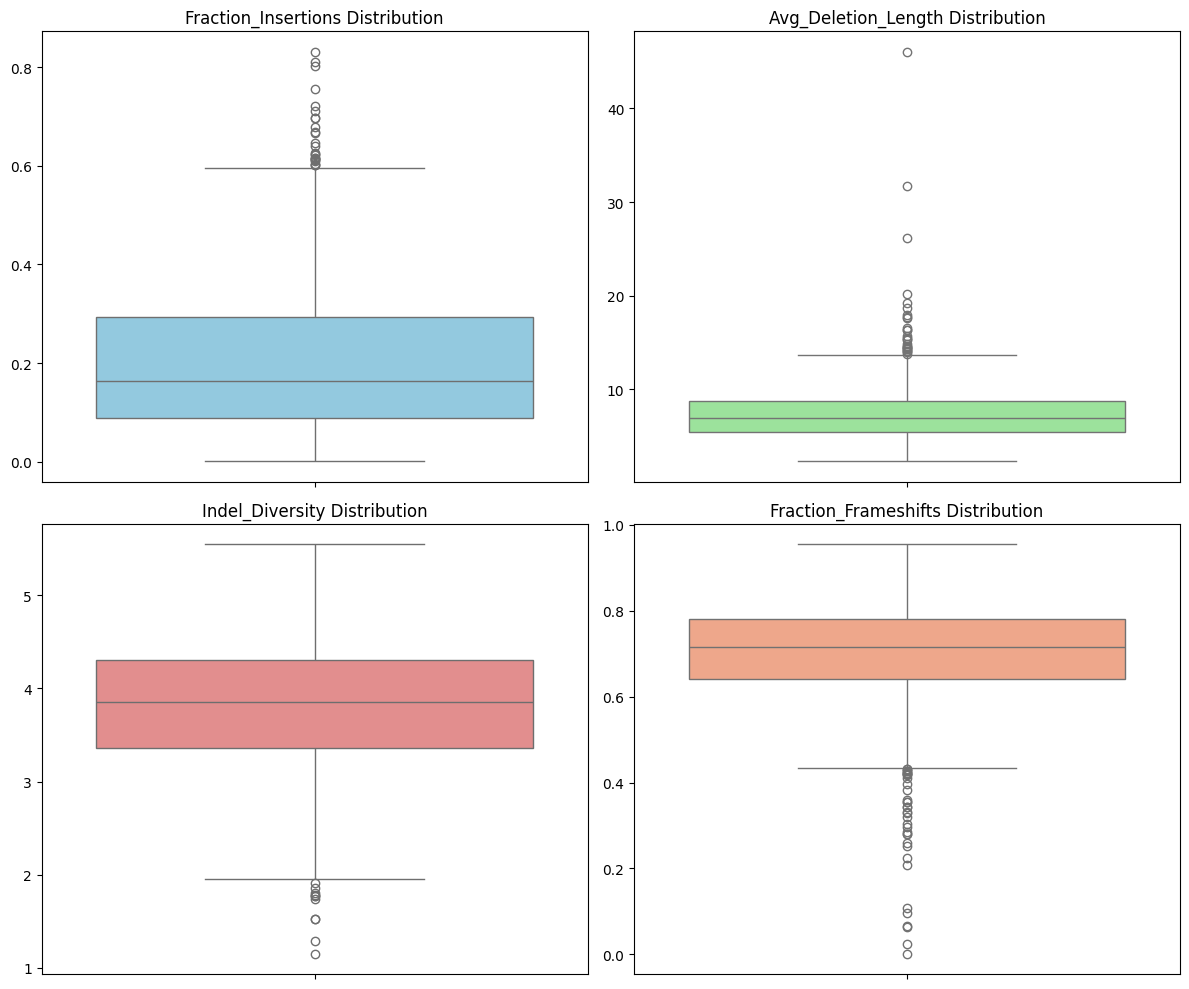

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.boxplot(data=y_train[:, 0], ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('Fraction_Insertions Distribution')

sns.boxplot(data=y_train[:, 1], ax=axs[0, 1], color='lightgreen')
axs[0, 1].set_title('Avg_Deletion_Length Distribution')

sns.boxplot(data=y_train[:, 2], ax=axs[1, 0], color='lightcoral')
axs[1, 0].set_title('Indel_Diversity Distribution')

sns.boxplot(data=y_train[:, 3], ax=axs[1, 1], color='lightsalmon')
axs[1, 1].set_title('Fraction_Frameshifts Distribution')

plt.tight_layout()
plt.show()


The boxplots illustrate the distributions of the four outcome variables and provide some of the following valuable insights: 

1. **Fraction_Insertions**:  
   The boxplot shows that most of the values are concentrated below 0.3, with a few outliers extending beyond 0.6. This suggests that insertion events are generally less frequent, with higher values being rare.

2. **Avg_Deletion_Length**:  
   The average deletion length has a median close to 10. Several significant outliers exist, with deletion lengths exceeding 20 or even 40. This indicates that deletions tend to be relatively small, although larger deletions occasionally occur.

3. **Indel_Diversity**:  
   The Indel_Diversity distribution is fairly symmetric, with a median around 4 and a small number of outliers below 2. Most cases show moderate diversity in repair outcomes, while a few have notably low variability.

4. **Fraction_Frameshifts**:  
   The fraction of frameshift mutations has a median around 0.7, with values generally above 0.5. However, a notable number of outliers are below 0.4, indicating that frameshift mutations dominate in most cases but are occasionally less frequent. 

These outliers probably represent rare but valid biological phenomena. In CRISPR-Cas9 experiments, unusual repair outcomes could be valid and provide insights into rare repair mechanisms or edge cases. 

#### 4.2.3 Correlation Matrix

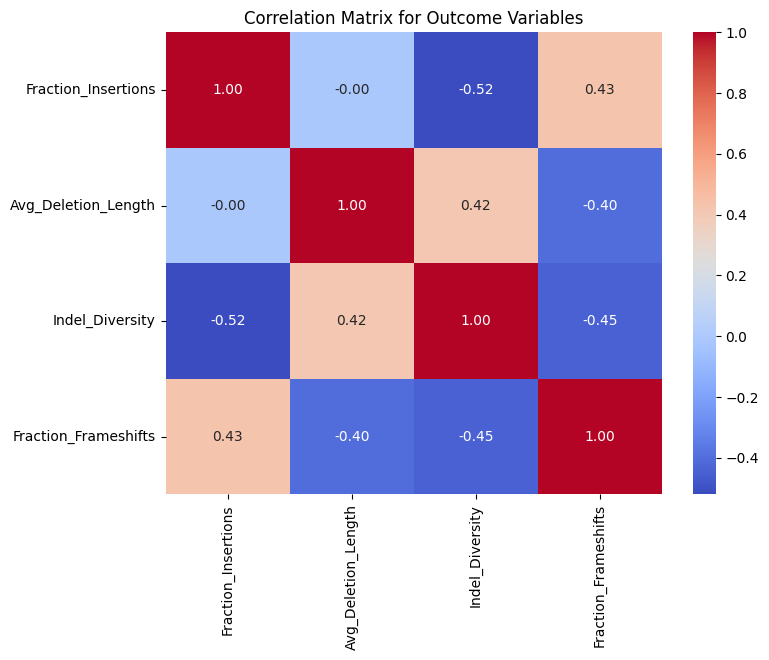

In [ ]:
# Computing correlation matrix
corr = train_data[['Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts']].corr()

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Outcome Variables')
plt.show()


According to the correlation matrix, we can see that some of the output variables seem to be correlated to each other. Specifically:
* **Indel_Diversity** and **Avg_Deletion_Length**
* **Fraction_Frameshifts** and **Fraction_Insertions**

Since some of the output variables are correlated, this suggests that they may share underlying patterns or factors that influence them together. A multi-output regression model is designed to capture these interdependencies, allowing the model to learn how the outputs relate to each other and potentially improve the prediction accuracy.

## 5. Model Setup

#### 5.1 Model

The goal of this project is to build a machine learning model capable of predicting four key repair outcomes of CRISPR-Cas9 editing experiments based on provided DNA sequences. Given the multi-output nature of this problem, the XGBoost Regressor is used as the base model and wrapped in a MultiOutputRegressor to handle the simultaneous prediction of all four outcomes. 

To ensure the best performance for the machine learning model, hyperparameter tuning was conducted using GridSearchCV with 5-fold cross-validation. This approach systematically tested different combinations of parameters to identify the ones that yielded the best results in terms of predictive performance. The parameters tuned included the learning rate, maximum depth of the trees, the number of estimators, and other regularization settings.

The cross-validation process provided a robust way to evaluate the model's performance on different subsets of the data, helping to mitigate overfitting and ensuring that the model generalizes well to unseen data.

The best parameters were identified through and the finalized model is reflected below. This approach guarantees that the final model is optimized for accuracy while being computationally efficient.

In [ ]:
# Initializing an XGBoost model wrapped in MultiOutputRegressor
gb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)
multi_target_gb = MultiOutputRegressor(gb_model)

# parameter grid
param_grid = {
    'estimator__n_estimators': [350],  # Add higher number of estimators
    'estimator__max_depth': [7],  # Include deeper trees for more complex models
    'estimator__learning_rate': [0.01],  # Explore different learning rates
    'estimator__subsample': [0.8],  # Vary subsample to control overfitting
    'estimator__min_child_weight': [7],  # Test larger values for more regularization
    'estimator__gamma': [0],  # Test higher gamma for more aggressive regularization
    'estimator__colsample_bytree': [1.0],  # New
    'estimator__colsample_bylevel': [0.6],  # New
    'estimator__colsample_bynode': [1.0],  # New
    'estimator__scale_pos_weight': [1],  # New
}

# GridSearchCV for hyperparameter tuning
clf = GridSearchCV(multi_target_gb, param_grid, cv=5, n_jobs=-1)
clf.fit(X_train_combined, y_train)

# best model from the grid search
best_gb_model = clf.best_estimator_

# Printing out the best parameters found by GridSearchCV
print("Best Parameters: ", clf.best_params_)

# Cross-validation scores for model evaluation
cv_scores = cross_val_score(multi_target_gb, X_train_combined, y_train, cv=5, scoring='r2', n_jobs=-1)
print("Cross-validation scores (R2):", cv_scores)
print("Mean cross-validation score (R2):", np.mean(cv_scores))
print("Standard deviation of cross-validation scores:", np.std(cv_scores))

# Predictions on the Kaggle test data
y_pred = best_gb_model.predict(X_test_combined)

Best Parameters:  {'estimator__colsample_bylevel': 0.6, 'estimator__colsample_bynode': 1.0, 'estimator__colsample_bytree': 1.0, 'estimator__gamma': 0, 'estimator__learning_rate': 0.01, 'estimator__max_depth': 7, 'estimator__min_child_weight': 7, 'estimator__n_estimators': 350, 'estimator__scale_pos_weight': 1, 'estimator__subsample': 0.8}
Cross-validation scores (R2): [0.22219598 0.10498771 0.13521444 0.22037586 0.02453819]
Mean cross-validation score (R2): 0.14146243551869997
Standard deviation of cross-validation scores: 0.0745465703121


#### 5.2 Saving results

The results were saved to a CSV file.

In [212]:
predictions_df = pd.DataFrame(y_pred, columns=["Fraction_Insertions", 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts'])
predictions_df['Id'] = predictions_df.index

predictions_df = predictions_df[['Id', 'Fraction_Insertions', 'Avg_Deletion_Length', 'Indel_Diversity', 'Fraction_Frameshifts']]
predictions_df.to_csv('predictions_boost_randomized.csv', index=False)

#### 5.3 Learning curves

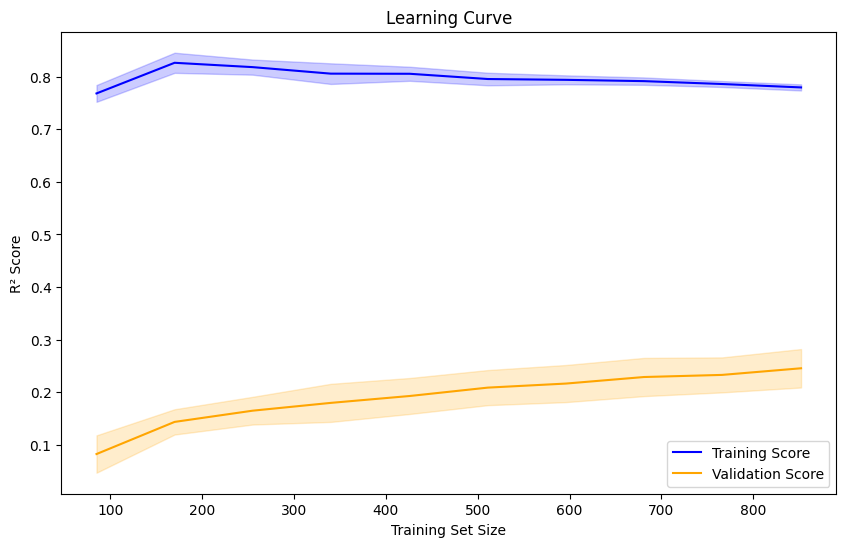

In [ ]:
# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    clf.best_estimator_,  # Replace with your model
    X_train_combined, 
    y_train, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.plot(train_sizes, test_mean, label="Validation Score", color="orange")

# Plot the variance as a shaded area
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="orange", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.show()


The learning curve shows the performance of the XGBoost model on both the training and validation sets as the training size increases. The training score starts high (around 0.8), reflecting a good fit on the training data even with smaller datasets, but it slightly decreases and stabilizes as the training set grows. This decline is expected as the model encounters more variability with larger datasets.

The validation score starts very low (around 0.1), indicating poor generalization when the training dataset is small. However, as the dataset grows, the validation score steadily improves and begins to plateau around 0.25–0.3. Despite this improvement, the noticeable gap between the training and validation curves may suggests that the model is struggling to generalize unseen data.

While adding more data has helped improve validation performance, the plateau indicates that the model may also benefit from regularization, improved feature engineering, or further hyperparameter tuning to enhance generalization.

# 6. Other models

Experimentation was made using other models such as: 
* **1-Nearest neighbor regression**: This model exhibited poor performance on the high-dimensional, complex DNA sequence dataset. The 1-NN algorithm struggles to capture intricate patterns and relationships that are necessary for accurate predictions
* **k-NN**: While k-NN is a non-parametric method that does not make assumptions about data distribution, it still faced challenges with this dataset. Different distance metrics, such as Euclidean and Manhattan distances, were tested, but the performance remained suboptimal. 
* **Support Vector Machine (SVM)**: Support Vector Regression (SVR) was used with MultiOutputRegressor to predict multiple target variables in our DNA sequence dataset. Hyperparameters were tuned using RandomizedSearchCV, focusing on kernel type, regularization (C), epsilon, and gamma. The RBF and Polynomial kernels were tested to capture the non-linear relationships in the data, aiming to optimize model complexity and generalization while reducing overfitting. The performance did not match the results achieved by XGBoost.

# 7. References:

- Nesvijevskaia, A., Ouillade, S., Guilmin, P., & Zucker, J.-D. (2021). The accuracy versus interpretability trade-off in fraud detection model. Data & Policy, 3, e12. doi:10.1017/dap.2021.3

- Leenay, R. T., Aghazadeh, A., Hiatt, J., Tse, D., Roth, T. L., Apathy, R., Shifrut, E., Hultquist, J. F., Krogan, N., Wu, Z., Cirolia, G., Canaj, H., Leonetti, M. D., Marson, A., May, A. P., & Zou, J. (2019). Large dataset enables prediction of repair after CRISPR–Cas9 editing in primary T cells. Nature Biotechnology, 37(9), 1034–1037. https://doi.org/10.1038/s41587-019-0203-2

‌

